In [ ]:
print("")

### Imports

In [ ]:
import load_data as dataloader
import InceptionTime.InceptionModule_keras
import InceptionTime.utils
import os
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

import random
seed = 18
random.seed(seed)

### Load data

In [ ]:
!pip install pyts
from pyts.datasets import ucr_dataset_list

# During development only choose a subset, to speed up load
DATASET_NAMES = ucr_dataset_list()[60:80]
print(DATASET_NAMES)

datasets_dict = {}
meta_data_dict = {'name': [], 'train_size': [], 'test_size':[] ,'length':[], 'test_proportion':[], "num_classes":[]}     # pandas dataframe with metadata about UCR datasets

CACHED_DATA_FOLDER = os.path.dirname(os.path.dirname(os.getcwd())) + "/Data"
for dataset_name in DATASET_NAMES:
    cache_path = os.path.join(CACHED_DATA_FOLDER, dataset_name)
    dataset_obj = dataloader.fetch_ucr_dataset(dataset=dataset_name, use_cache=True, data_home=cache_path)
    datasets_dict[dataset_name] = dataset_obj

    # Filter the datasets depending on number of classes
    num_classes = len(np.unique(dataset_obj['target_train']))
    #if num_clases < 3:

    data_length = dataset_obj['data_train'].shape[1]
    train_size = dataset_obj['data_train'].shape[0]
    test_size = dataset_obj['data_test'].shape[0]
    (labels,counts) = np.unique(dataset_obj['target_test'],return_counts=True)
    test_proportion = counts[0]/(counts[0]+counts[1])

    meta_data_dict['length'].append(data_length)
    meta_data_dict['train_size'].append(train_size)
    meta_data_dict['test_size'].append(test_size)
    meta_data_dict['name'].append(dataset_name)
    meta_data_dict['test_proportion'].append(test_proportion)
    meta_data_dict['num_classes'].append(num_classes)


meta_df = pd.DataFrame(data=meta_data_dict)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.3 MB/s eta 0:00:00
['InlineSkate', 'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'InsectWingbeatSound', 'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lightning2', 'Lightning7', 'Mallat', 'Meat', 'MedicalImages', 'MelbournePedestrian', 'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxOutlineCorrect', 'MiddlePhalanxTW', 'MixedShapes', 'MixedShapesSmallTrain', 'MoteStrain', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2']


### Filter out unreasonable datasets

In [ ]:
reasonable_datasets = meta_df.loc[(meta_df['train_size']>200)&(meta_df['train_size']<2000)& (meta_df['test_size']<2*meta_df['train_size']) & (meta_df['length']<1000)]
print(reasonable_datasets)
split = int(reasonable_datasets.shape[0]/3)
print("sofia:\n", reasonable_datasets['name'][0:split].to_string(index=False).split())
print("ayman:\n", reasonable_datasets['name'][split:2*split].to_string(index=False).split())
print("nils:\n", reasonable_datasets['name'][2*split:].to_string(index=False).split())



                            name  train_size  test_size  length  \
5         LargeKitchenAppliances         375        375     720   
10                 MedicalImages         381        760      99   
12  MiddlePhalanxOutlineAgeGroup         400        154      80   
13   MiddlePhalanxOutlineCorrect         600        291      80   
14               MiddlePhalanxTW         399        154      80   
18    NonInvasiveFetalECGThorax1        1800       1965     750   
19    NonInvasiveFetalECGThorax2        1800       1965     750   

    test_proportion  num_classes  
5          0.500000            3  
10         0.606299           10  
12         0.296000            3  
13         0.429553            2  
14         0.362319            6  
18         0.551724           42  
19         0.551724           42  
sofia:
 ['LargeKitchenAppliances', 'MedicalImages']
ayman:
 ['MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxOutlineCorrect']
nils:
 ['MiddlePhalanxTW', 'NonInvasiveFetalECGThorax1', 'N

### Preprocess and augment data

In [ ]:
from sklearn.model_selection import train_test_split
from surrogate_augmentation import refined_AAFT_surrogates, correlated_noise_surrogates, white_noise_surrogates, AAFT_surrogates


def augment_data(X):
    n_iters = 10
    X_refined_AAFT = refined_AAFT_surrogates(X, n_iters)
    X_AAFT = AAFT_surrogates(X)
    X_correlated_noise = correlated_noise_surrogates(X)
    X_white_noise = white_noise_surrogates(X)
    return X_refined_AAFT, X_AAFT, X_correlated_noise, X_white_noise


def preprocess_data(dataset_name):
    processed_data_dict = {}
    #for name, dataset_object in datasets_dict.items():
    X = datasets_dict[dataset_name]['data_train']
    Y = datasets_dict[dataset_name]['target_train']
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.25, stratify=Y)
    x_test = datasets_dict[dataset_name]['data_test']
    y_test = datasets_dict[dataset_name]['target_test']

    x_refined_AAFT, x_AAFT, x_correlated_noise, x_white_noise = augment_data(x_train)

    num_classes = len(np.unique(np.concatenate((y_train, y_val, y_test), axis=0)))

    y_train, y_val, y_test = InceptionTime.utils.transform_labels(y_train, y_val, y_test)

    # save orignal y because later we will use binary
    y_test = y_test.astype(np.int64)
    y_train = y_train.astype(np.int64)
    y_val = y_val.astype(np.int64)

    # transform the labels from integers to one hot vectors
    enc = OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test, y_val), axis=0).reshape(-1, 1))
    y_train_onehot = enc.transform(y_train.reshape(-1, 1)).toarray()
    y_test_onehot = enc.transform(y_test.reshape(-1, 1)).toarray()
    y_val_onehot = enc.transform(y_val.reshape(-1, 1)).toarray()

    if len(x_train.shape) == 2:  # if univariate
        # add a dimension to make it multivariate with one dimension
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    processed_data_dict = {"x_train":x_train, "y_train":y_train, "y_train_onehot":y_train_onehot,
                                "x_test":x_test, "y_test":y_test, "y_test_onehot":y_test_onehot,
                                "x_val":x_val, "y_val":y_val, "y_val_onehot":y_val_onehot,
                                "num_classes":num_classes,
                                "x_refined_AAFT":x_refined_AAFT, "x_correlated_noise":x_correlated_noise,
                                "x_AAFT":x_AAFT, "x_white_noise":x_white_noise}


    return processed_data_dict

### Pre-train on augmented data

In [ ]:
from sklearn.model_selection import train_test_split
from surrogate_augmentation import refined_AAFT_surrogates, correlated_noise_surrogates, white_noise_surrogates, AAFT_surrogates


def augment_data(X, aug_type):
    n_iters = 50
    if aug_type=="refined_AAFT":
      return refined_AAFT_surrogates(X, n_iters)
    elif aug_type=="AAFT":
      return AAFT_surrogates(X)
    elif aug_type=="correlated_noise":
      correlated_noise_surrogates(X)
    elif aug_type=="white_noise":
      return white_noise_surrogates(X)
    elif aug_type=="no_aug":
      return X
    else:
      print("invalid augmentation type")

def preprocess_data(dataset_name, aug_type):

    processed_data_dict = {}
    X = augment_data(datasets_dict[dataset_name]['data_train'], aug_type)

    Y = datasets_dict[dataset_name]['target_train']
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.25, stratify=Y)
    x_test = datasets_dict[dataset_name]['data_test']
    y_test = datasets_dict[dataset_name]['target_test']

    num_classes = len(np.unique(np.concatenate((y_train, y_val, y_test), axis=0)))

    y_train, y_val, y_test = InceptionTime.utils.transform_labels(y_train, y_val, y_test)

    # save orignal y because later we will use binary
    y_test = y_test.astype(np.int64)
    y_train = y_train.astype(np.int64)
    y_val = y_val.astype(np.int64)

    # transform the labels from integers to one hot vectors
    enc = OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test, y_val), axis=0).reshape(-1, 1))
    y_train_onehot = enc.transform(y_train.reshape(-1, 1)).toarray()
    y_test_onehot = enc.transform(y_test.reshape(-1, 1)).toarray()
    y_val_onehot = enc.transform(y_val.reshape(-1, 1)).toarray()

    if len(x_train.shape) == 2:  # if univariate
        # add a dimension to make it multivariate with one dimension
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    processed_data_dict = {"x_train":x_train, "y_train":y_train, "y_train_onehot":y_train_onehot,
                                "x_test":x_test, "y_test":y_test, "y_test_onehot":y_test_onehot,
                                "x_val":x_val, "y_val":y_val, "y_val_onehot":y_val_onehot,
                                "num_classes":num_classes}


    return processed_data_dict

### Pre-train on augmented data

In [ ]:

N_EPOCHS = 500
N_ENSEMBLE = 1

pretrained_networks = {}

augmentation_types = ["refined_AAFT"] #["no_aug", "refined_AAFT", "white_noise", "AAFT"]

pretrain_metrics = {}
#for name, dataset_object in processed_data_dict.items():


for name in ["LargeKitchenAppliances"]:

  for aug_type in augmentation_types:
      print(aug_type)

      pretrain_metrics[aug_type] = {"loss":[], "recall":[], "precision":[], "accuracy":[], "f1_score":[]}

      pretrained_networks[aug_type] = []

      for i in range(N_ENSEMBLE):
        # Do this for each ensemble member so that we get slightly different training sets for each

        processed_data = preprocess_data(name, aug_type)


        num_classes = processed_data['num_classes']
        input_shape = (processed_data["x_train"].shape[1], 1)

        verbose = True
        use_residual = True
        early_stopping = False

        checkpoints_path = ""
        inception_net = InceptionTime.InceptionModule_keras.Classifier_INCEPTION(checkpoints_path,
                          input_shape, num_classes, save_weights=False, verbose=verbose,
                            use_residual=use_residual, lr=0.001, wd=None, early_stop=early_stopping)
        # Do not use validation data now because we only want to train a short while, and don't use early stopping etc
        history = inception_net.fit(processed_data['x_train'], processed_data['y_train_onehot'], processed_data['x_val'], processed_data['y_val_onehot'], nb_epochs=N_EPOCHS, plot_test_acc=True)

        # Save metrics
        pretrain_metrics[aug_type]['loss'].append(history.history['loss'])
        pretrain_metrics[aug_type]['accuracy'].append(history.history['accuracy'])
        pretrain_metrics[aug_type]['precision'].append(history.history['Precision'])
        pretrain_metrics[aug_type]['recall'].append(history.history['Recall'])
        pretrain_metrics[aug_type]['f1_score'].append(history.history['F1_score'])

        pretrained_networks[aug_type].append(inception_net)




refined_AAFT
Epoch 1/500
5/5 [==============================] - 20s 590ms/step - loss: 1.1477 - accuracy: 0.3345 - F1_score: 0.0956 - Precision: 1.0000 - Recall: 0.0503 - val_loss: 1.0985 - val_accuracy: 0.3298 - val_F1_score: 0.0000e+00 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - lr: 0.0010
Epoch 2/500
5/5 [==============================] - 0s 98ms/step - loss: 1.1355 - accuracy: 0.3345 - F1_score: 0.0705 - Precision: 1.0000 - Recall: 0.0366 - val_loss: 1.0954 - val_accuracy: 0.3298 - val_F1_score: 0.0000e+00 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - lr: 0.0010
Epoch 3/500
5/5 [==============================] - 1s 103ms/step - loss: 1.1208 - accuracy: 0.3345 - F1_score: 0.0425 - Precision: 0.8000 - Recall: 0.0219 - val_loss: 1.0945 - val_accuracy: 0.3298 - val_F1_score: 0.0000e+00 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - lr: 0.0010
Epoch 4/500
5/5 [==============================] - 1s 103ms/step - loss: 1.1044 - accuracy: 0.3416 - F1_score: 0.0204

### After-train on real data

In [ ]:

N_EPOCHS = 500
N_ENSEMBLE = 1

use_pretrained = True

trained_networks = {}
train_metrics = {}
val_metrics = {}

#for name, dataset_object in processed_data_dict.items():
for name in ["LargeKitchenAppliances"]:
  num_classes = processed_data['num_classes']
  for aug_type in augmentation_types:
    trained_networks[aug_type] = []
    train_metrics[aug_type] = {"loss":[], "recall":[], "precision":[], "accuracy":[], "f1_score":[]}
    val_metrics[aug_type] = {"loss":[], "recall":[], "precision":[], "accuracy":[], "f1_score":[]}

    for i in range(N_ENSEMBLE):
      checkpoints_path = ""
      processed_data = preprocess_data(name, "no_aug")
      x_train=processed_data['x_train']
      input_shape = x_train.shape[1:]

      verbose = True
      use_residual = True
      early_stopping = False

      if use_pretrained:
        inception_net = pretrained_networks[aug_type][i]
      else:
        inception_net = InceptionTime.InceptionModule_keras.Classifier_INCEPTION(checkpoints_path,
                            input_shape, num_classes, save_weights=False, verbose=verbose, use_residual=use_residual,
                                                                    lr=0.001, wd=None, early_stop=early_stopping)

      history = inception_net.fit(x_train, processed_data['y_train_onehot'], processed_data['x_val'], processed_data['y_val_onehot'], nb_epochs=N_EPOCHS, plot_test_acc=True)

      # Save metrics
      train_metrics[aug_type]['loss'].append(history.history['loss'])
      train_metrics[aug_type]['accuracy'].append(history.history['accuracy'])
      train_metrics[aug_type]['precision'].append(history.history['Precision'])
      train_metrics[aug_type]['recall'].append(history.history['Recall'])
      train_metrics[aug_type]['f1_score'].append(history.history['F1_score'])
      val_metrics[aug_type]['loss'].append(history.history['val_loss'])
      val_metrics[aug_type]['accuracy'].append(history.history['val_accuracy'])
      val_metrics[aug_type]['precision'].append(history.history['val_Precision'])
      val_metrics[aug_type]['recall'].append(history.history['val_Recall'])
      val_metrics[aug_type]['f1_score'].append(history.history['val_F1_score'])

      trained_networks[aug_type].append(inception_net)


Epoch 1/500
5/5 [==============================] - 1s 126ms/step - loss: 0.6859 - accuracy: 0.6975 - F1_score: 0.4280 - Precision: 1.0000 - Recall: 0.2725 - val_loss: 0.8010 - val_accuracy: 0.7234 - val_F1_score: 0.3931 - val_Precision: 1.0000 - val_Recall: 0.2446 - lr: 1.0000e-04
Epoch 2/500
5/5 [==============================] - 1s 106ms/step - loss: 0.7132 - accuracy: 0.7117 - F1_score: 0.4184 - Precision: 1.0000 - Recall: 0.2648 - val_loss: 0.8008 - val_accuracy: 0.7340 - val_F1_score: 0.3964 - val_Precision: 1.0000 - val_Recall: 0.2472 - lr: 1.0000e-04
Epoch 3/500
5/5 [==============================] - 1s 109ms/step - loss: 0.7019 - accuracy: 0.6975 - F1_score: 0.4307 - Precision: 1.0000 - Recall: 0.2746 - val_loss: 0.8001 - val_accuracy: 0.7234 - val_F1_score: 0.4030 - val_Precision: 1.0000 - val_Recall: 0.2524 - lr: 1.0000e-04
Epoch 4/500
5/5 [==============================] - 1s 106ms/step - loss: 0.6922 - accuracy: 0.7224 - F1_score: 0.4324 - Precision: 1.0000 - Recall: 0.2765

### Plot training curves for a single network

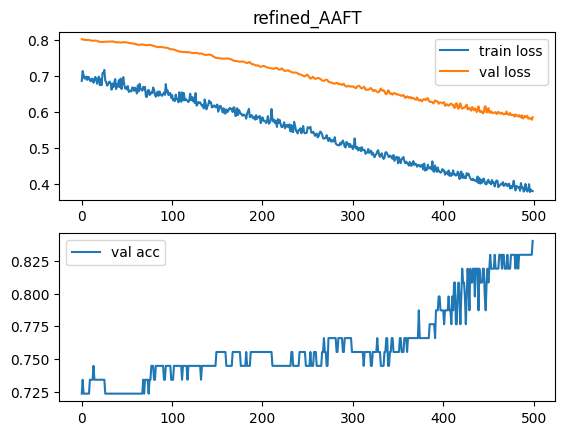

In [ ]:
from matplotlib import pyplot as plt


fig, axs = plt.subplots(2, len(augmentation_types))

# We are currently only considering single networks, no ensemble
ensemble_member = 0
for i in range(len(augmentation_types)):
    aug_type=augmentation_types[i]
    loss = train_metrics[aug_type]['loss'][ensemble_member]
    val_loss = val_metrics[aug_type]['loss'][ensemble_member]
    val_accuracy = val_metrics[aug_type]['accuracy'][ensemble_member]
    if len(augmentation_types)==1:
      axs[0].plot([i for i in range(len(loss))], loss, label="train loss")
      axs[0].plot([i for i in range(len(val_loss))], val_loss, label="val loss")
      axs[0].set_title(aug_type)
      axs[1].plot([i for i in range(len(loss))], val_accuracy, label="val acc")
      axs[0].legend()
      axs[1].legend()
    else:
      axs[0,i].plot([i for i in range(len(loss))], loss, label="train loss")
      axs[0,i].plot([i for i in range(len(val_loss))], val_loss, label="val loss")
      axs[0,i].set_title(aug_type)
      axs[1,i].plot([i for i in range(loss)], val_accuracy, label="val acc")
      axs[0,i].legend()
      axs[1,i].legend()


plt.show()